# Rumo 
## Sprint 01
### Análise Exploratória dos dados

### BASE DE DADOS:
A base de dados fornecida foi uma planilha Excel (formato .xlsb) contendo duas abas:  

`Circulação:` > Contém informações macro relativas à malha/trajeto/seção e deslocamento do trem (trem = composição de _m_ locomotivas + _n_ vagões), ordem de serviço, horários de saída e de chegada, e tempos gastos com anomalias.  

`Ficha_trem:` > Contém informações detalhadas sobre os vagões e locomotivas quem compõem cada trem da aba anterior, por trajeto. São disponibilizadas informações como peso bruto, peso líquido, comprimento e código único de identificação do vagão/locomotiva, dentre outros.

*Para este exercício, somente a aba `Circulacao` será utilizada.*

### OBJETIVO DO PROJETO:
Estimar o horário de chegada de trens ao destino, considerando todas as possíveis variáveis de entrada do arquivo e, principalmente, tendo em mente que a a previsão de chegada do trem **precisa ser recalculada a cada avanço uma seção bloqueio considerando todos os trens que cruzarão a rota do trem sob análise**.

*Na imagem abaixo são exibidas as malhas utilizadas pela rumo, as quais são divididas em Trechos, que são subdivididos em Subtrechos, que são subdivididos em Locais, que são subdivididos em Seções de Bloqueio. 

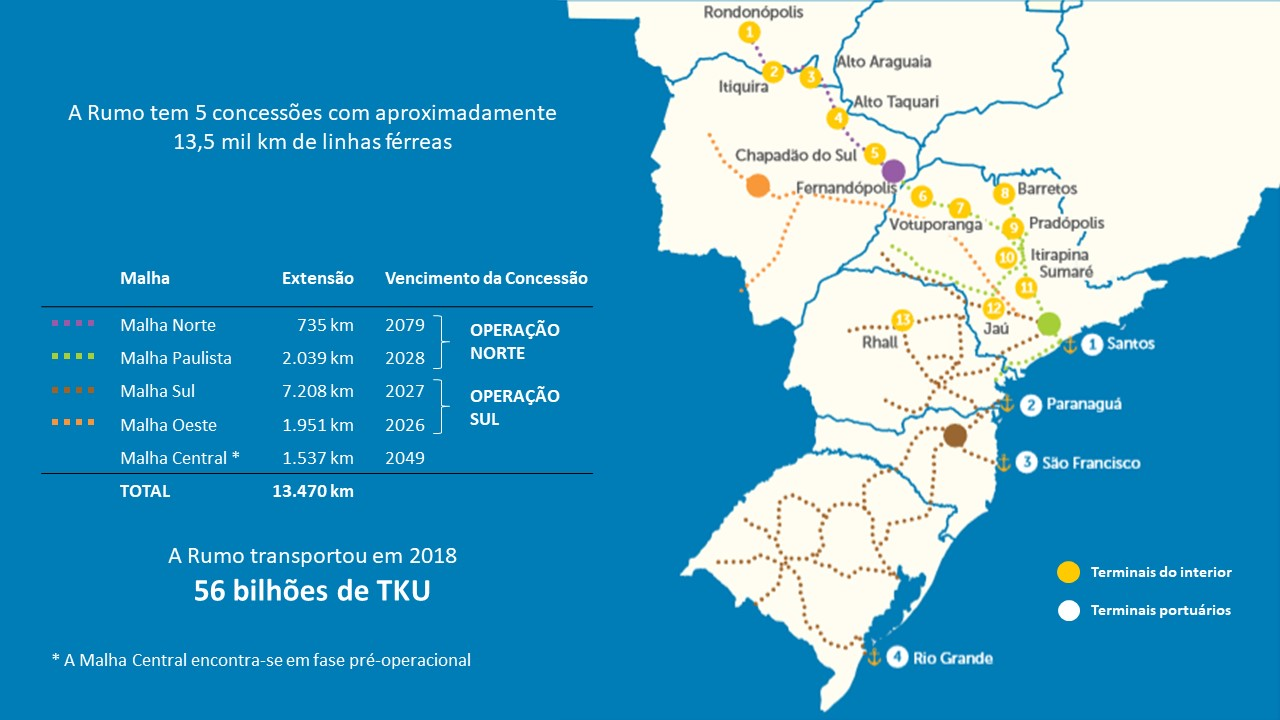

In [4]:

#display(Image("mapa_rumo.JPG"))

### Pacotes e setup

In [1]:
import pandas as pd
import sys, math
import numpy as np
import pylab as plt
import seaborn as sns
from matplotlib import colors,cm
from mpl_toolkits.mplot3d import Axes3D
import warnings
from IPython.display import Image, display

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (30.0, 15.0)
topcolor = ['#35d457','#35d457','#31a5d4','#31a5d4','#2a66b5','#2a66b5']
botcolor = ['#ebda28','#ebda28','#de7c1b','#de7c1b','#e03b28','#e03b28']

### Importando arquivo de dados

In [2]:
path = "./circulacao.csv"
df = pd.read_csv(path, sep = ";")
display(df.head())

,Unnamed: 0,SECAO_BLOQUEIO,LOCAL,SUB_TRECHO,TRECHO,CORREDOR,PREFIXO,IDANALISE,IDTREM,IDSUBTRECHO,...,CONDUCAO,PERMANECIA,CRUZAMENTO,ANOMALIA,PROPAGACAO,ATIVO,DTVERSION,PUBLICAR,IDANALISEPARTICIONADA,PKID
0,0,ZQBZBV,ZQBZBV,T1 - ZQBZBV/ZDR,TRECHO 1 - ZBV/ZPT,NORTE - LARGA,R67,4258247.0,2745064.0,154.0,...,203.0,0.0,0.0,0.0,0.0,1.0,2019-09-10 12:19:06.000000000,0.0,NaN,253.0
1,1,ZQBZBV,ZQBZBV,T1 - ZQBZBV/ZDR,TRECHO 1 - ZBV/ZPT,NORTE - LARGA,X37,4258313.0,2745154.0,154.0,...,213.0,0.0,0.0,0.0,0.0,1.0,2019-09-10 12:19:06.000000000,0.0,NaN,319.0
2,2,ZQBZBV,ZQBZBV,T1 - ZQBZBV/ZDR,TRECHO 1 - ZBV/ZPT,NORTE - LARGA,L31,4258378.0,2745102.0,154.0,...,237.0,0.0,0.0,0.0,0.0,1.0,2019-09-10 12:19:06.000000000,0.0,NaN,384.0
3,3,ZDR1,ZDR,T0 - ZDR/PCZ,TRECHO 0 - ZPT/PSN-PCZ,NORTE - LARGA,C81,4257853.0,2745334.0,156.0,...,0.0,3789.0,0.0,0.0,0.0,1.0,2019-09-10 12:14:25.000000000,0.0,NaN,128251.0
4,4,LMRP,LMR,LMR-LID,LMR-LID,PARANAGUÁ,K01,4259283.0,2745433.0,135.0,...,0.0,1006.0,0.0,0.0,0.0,1.0,2019-09-10 12:32:12.000000000,0.0,NaN,128314.0


### Variáveis dependentes (para predição -y-):
1. `CONDUCAO`   > Tempo de condução
2. `PERMANECIA` > Tempo de permanência em uma determinada Seção Bloqueio
3. `CRUZAMENTO` > Parada devido a um cruzamento
4. `ANOMALIA`   > Autoexplicativo
4. `PROPAGACAO` > Deslocamento prejudicado por parada de outros trens à frente.

### Variável independente:

1. `SECAO_BLOQUEIO`   > A seção bloqueio pode ser compreendida como os *n* subtrechos que compõem a rota de um trem.

In [3]:
df_nova = df[['SECAO_BLOQUEIO', 'CONDUCAO', 'PERMANECIA', 'CRUZAMENTO', 'ANOMALIA', 'PROPAGACAO']]
display(df_nova.head())

,SECAO_BLOQUEIO,CONDUCAO,PERMANECIA,CRUZAMENTO,ANOMALIA,PROPAGACAO
0,ZQBZBV,203.0,0.0,0.0,0.0,0.0
1,ZQBZBV,213.0,0.0,0.0,0.0,0.0
2,ZQBZBV,237.0,0.0,0.0,0.0,0.0
3,ZDR1,0.0,3789.0,0.0,0.0,0.0
4,LMRP,0.0,1006.0,0.0,0.0,0.0


In [4]:
df_nova['TEMPO_TOTAL'] = df_nova['CONDUCAO'] + df_nova['PERMANECIA'] + df_nova['CRUZAMENTO'] + df_nova['ANOMALIA'] + df_nova['PROPAGACAO']
display(df_nova.head())

,SECAO_BLOQUEIO,CONDUCAO,PERMANECIA,CRUZAMENTO,ANOMALIA,PROPAGACAO,TEMPO_TOTAL
0,ZQBZBV,203.0,0.0,0.0,0.0,0.0,203.0
1,ZQBZBV,213.0,0.0,0.0,0.0,0.0,213.0
2,ZQBZBV,237.0,0.0,0.0,0.0,0.0,237.0
3,ZDR1,0.0,3789.0,0.0,0.0,0.0,3789.0
4,LMRP,0.0,1006.0,0.0,0.0,0.0,1006.0


In [5]:
############## Preenchimento de campos em branco ###################
df_nova = df_nova.fillna(0)

df_nova[['SB_Num']]  = df_nova[['SECAO_BLOQUEIO']]

In [6]:
############## Conversão da variável categórica para numérica   ##########################

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_nova[['SB_Num']]  = le.fit_transform(df_nova[['SB_Num']])
df_nova[['SB_Norm']] = df_nova[['SB_Num']]

display(df_nova.head())

,SECAO_BLOQUEIO,CONDUCAO,PERMANECIA,CRUZAMENTO,ANOMALIA,PROPAGACAO,TEMPO_TOTAL,SB_Num,SB_Norm
0,ZQBZBV,203.0,0.0,0.0,0.0,0.0,203.0,1039,1039
1,ZQBZBV,213.0,0.0,0.0,0.0,0.0,213.0,1039,1039
2,ZQBZBV,237.0,0.0,0.0,0.0,0.0,237.0,1039,1039
3,ZDR1,0.0,3789.0,0.0,0.0,0.0,3789.0,909,909
4,LMRP,0.0,1006.0,0.0,0.0,0.0,1006.0,501,501


In [7]:
#################          Normalizando a variável          ##################
from sklearn.preprocessing import StandardScaler

X = df_nova[['SB_Norm']]

scaler = StandardScaler().fit(X)
X_Rs = scaler.transform(X)


df_nova[['SB_Norm']] = X_Rs
display(df_nova.head())

,SECAO_BLOQUEIO,CONDUCAO,PERMANECIA,CRUZAMENTO,ANOMALIA,PROPAGACAO,TEMPO_TOTAL,SB_Num,SB_Norm
0,ZQBZBV,203.0,0.0,0.0,0.0,0.0,203.0,1039,1.226102
1,ZQBZBV,213.0,0.0,0.0,0.0,0.0,213.0,1039,1.226102
2,ZQBZBV,237.0,0.0,0.0,0.0,0.0,237.0,1039,1.226102
3,ZDR1,0.0,3789.0,0.0,0.0,0.0,3789.0,909,0.866373
4,LMRP,0.0,1006.0,0.0,0.0,0.0,1006.0,501,-0.262622


In [8]:
#####################################     SEPARAÇÃO DA BASE     ####################################
from sklearn.model_selection import train_test_split


df_train, df_test = train_test_split(df_nova, test_size=0.30, shuffle=True)

print("Original df", df_nova.shape, "\nTrain      ", df_train.shape, "\nTest       ", df_test.shape)

Original df (266604, 9) 
Train       (186622, 9) 
Test        (79982, 9)


# Análise Inicial com algoritmos de Machine Learning

### Importar Bibliotecas de machine learning

In [9]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

#requer sklearn:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

### Regressão Linear, SGD, KNN e Tree:

In [10]:
#######################    BIBLIOTECAS    #####################
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree         import DecisionTreeRegressor 
from sklearn.neighbors    import KNeighborsRegressor
from sklearn.neighbors    import KNeighborsClassifier

from matplotlib           import pyplot as plt

X_train = df_train[['SB_Norm']]
Y_train = df_train[['CONDUCAO']]

print(X_train.shape)
print(Y_train.shape)

######################   FITS    ####################
linear = LinearRegression().fit(X_train,Y_train)
sgd    = SGDRegressor(max_iter=5000,alpha=0).fit(X_train,Y_train)
#neigh  = KNeighborsRegressor(n_neighbors=2,weights='uniform').fit(X_train,Y_train)
tree   = DecisionTreeRegressor().fit(X_train,Y_train)

(186622, 1)
(186622, 1)


In [11]:
##################    Fórmula do R² e RSS      #####################

from sklearn.metrics import r2_score
def calc_rss(y,predicted):
    return float(((predicted - y) ** 2).sum())
    
def calc_r2(y,predicted):
    return r2_score(y, predicted)

In [179]:
X_test = df_test[['SB_Norm']]
Y_test = df_test.CONDUCAO

print(X_test.shape)
print(Y_test.shape)

(79982, 1)
(79982,)


In [156]:
a = range(1,100)
r2k = 0
l   = 0
for i in a:
    neigh  = KNeighborsRegressor(n_neighbors=i,weights='uniform').fit(X_train,Y_train)
    r2  = calc_r2(Y_test,neigh.predict(X_test))
    if r2 > r2k:
        r2k = r2
        l = i
print('Best Result: k = ', l, ', R² = %.3f'% r2k)

Best Result: k =  28 , R² = 0.440


In [168]:
################   Teste para descobrir qual o melhor K    #####################

# O teste foi realizado até k = 100. Em alguns casos em que há um grande volume de dados talvez esse número seja insuficiente.

k2         = 0
error_rate = []
low_error  = 1
        
a = range(1,100)
for i in a:
    error = np.mean(pred_i != Y_test)
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,Y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(error)
    if error < low_error:
        low_error = error
        k2 = i
print('k otimizado = ', k2,'Menor erro = ', low_error)

k otimizado =  99 Menor erro =  0.9666424945612763


Text(0, 0.5, 'Error Rate')

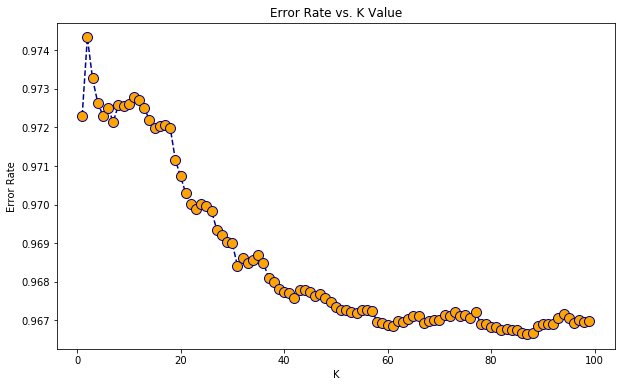

In [169]:
###################      Plot do gráfico de erros - Somente para KNN     ###################

plt.figure(figsize=(10,6))
plt.plot(a,error_rate,color='darkblue', linestyle='dashed', marker='o',
         markerfacecolor='orange', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [171]:
############## Cálculo do KNN após a determinação do melhor k ########

neigh  = KNeighborsRegressor(n_neighbors=k2,weights='uniform').fit(X_train,Y_train)
print(k2)

87


In [172]:
############################ RESULTADOS FINAIS DE R² E RSS ####################

r2  = calc_r2(Y_test,linear.predict(X_test))
print('****** R²: ******')
print('Linear: %.4f'% r2)

r2  = calc_r2(Y_test,sgd.predict(X_test))
print('SGD:    %.4f'% r2)

r2  = calc_r2(Y_test,neigh.predict(X_test))
print('KNN:    %.4f'% r2)

r2  = calc_r2(Y_test,tree.predict(X_test))
print('TREE:   %.4f'% r2)

****** R²: ******
Linear: 0.0038
SGD:    0.0038
KNN:    0.3855
TREE:   0.4718


In [185]:
rss = calc_rss(Y_test,np.array(linear.predict(X_test).reshape(79982)))
print('***** RSS: *****')
print('Linear: %.0f'% rss)

rss = calc_rss(Y_test,np.array(sgd.predict(X_test).reshape(79982)))
print('SGD:    %.0f'% rss)

rss = calc_rss(Y_test,np.array(neigh.predict(X_test).reshape(79982)))
print('KNN:    %.0f'% rss)

rss = calc_rss(Y_test,np.array(tree.predict(X_test).reshape(79982)))
print('TREE:   %.0f'% rss)

***** RSS: *****
Linear: 115701396391
SGD:    115709482029
KNN:    71377712868
TREE:   61353464152


## CONCLUSÃO:

### A Regression Tree retornou os melhores resultados tanto do R² quanto do RSS